In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2025-01-14 22:31:12.407715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 22:31:12.498894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736893872.545708    1080 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736893872.559435    1080 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 22:31:12.633266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
data = pd.read_csv('DataIteration.csv')

In [3]:
def encode(db):
    dtypes = list(zip(db.dtypes.index, map(str, db.dtypes)))
    for k,dtype in dtypes:
        if dtype == 'object':
            db[k] = LabelEncoder().fit_transform(db[k])
    return db.astype('float')

In [4]:
data = encode(data)

In [5]:
target = np.where(( data['lifecycle:transition'] == 'ate_abort') | (data["iteration"] >= 3),1,0)
iter = data.pop("iteration")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data,target,train_size=0.8,shuffle=False)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(min_delta = 0.001, patience=12, restore_best_weights=True)

In [8]:
import keras_tuner as kt

In [9]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_hidden_activation1 = hp.Choice('activition', values=['relu','tanh'])
  hp_hidden_activation2 = hp.Choice('activition', values=['relu','tanh'])
  hp_hidden_activation3 = hp.Choice('activition', values=['relu','tanh'])
  hp_hidden_activation4 = hp.Choice('activition', values=['relu','tanh'])
  hp_dense_activation = hp.Choice('activation', values=['softmax','sigmoid'])
  
  
  model.add(tf.keras.layers.Reshape((17,-1),input_shape=(17,)))
  model.add(layers.Conv1D(hp_units1, 3, activation = hp_hidden_activation1))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(layers.Conv1D(hp_units2, 3, activation=hp_hidden_activation2))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(layers.Conv1D(hp_units3, 3, activation=hp_hidden_activation3))
  model.add(layers.MaxPooling1D())
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())
      
  model.add(layers.Flatten())
  model.add(layers.Dense(hp_units4, activation=hp_hidden_activation4))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(1,activation = hp_dense_activation))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [10]:
input_shape = (x_train.shape[0],x_train.shape[1],1)
model_cnn = tf.keras.models.Sequential([    
    tf.keras.layers.Reshape((17,-1),input_shape=(17,)),                                    
    layers.Conv1D(128, 3, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    
    layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
        
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

/home/modzo/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1736705334.103472  159157 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


I0000 00:00:1736893881.919534    1080 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8761 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
# input_shape = (1, 10, 128)
# x = tf.random.normal(input_shape)
# y = tf.keras.layers.Conv1D(
# 32, 3, activation='relu', input_shape=input_shape)(x)
# print(x[0][0])
# print(y.shape)

In [12]:
sm_train,sm_test,sy_train,sy_test = train_test_split(x_train,y_train,train_size=0.1,shuffle=False)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [13]:
tuner.search(sm_train, sy_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [15]:
model_cnn.summary()

NameError: name 'model_cnn' is not defined

In [16]:
# keras.utils.plot_model(model_cnn, show_shapes=True)

In [17]:
model_cnn.compile(optimizer='adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy']
             )

In [18]:
# x_test.shape

In [15]:
db = tf.reshape(data,(1, data.shape[1], -1))

In [16]:
train = tf.reshape(x_train,(-1, 17, 1))

In [17]:
test = tf.reshape(x_test,(-1,17,1))

In [18]:
input_shape = (train.shape[0],train.shape[1],1)
input_shape

(961813, 17, 1)

In [19]:
train.shape

TensorShape([961813, 17, 1])

In [14]:
model_cnn = tuner.hypermodel.build(best_hps)

/home/modzo/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
history1 = model_cnn.fit(x_train,y_train,
                    validation_split=0.2,
                    epochs = 100,
                    batch_size = 256,
                    callbacks=early,
                   )

Epoch 1/100


I0000 00:00:1736893903.435382  244117 service.cc:148] XLA service 0x7fcb0c0088f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736893903.436411  244117 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-01-14 22:31:43.522956: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736893903.865516  244117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  50/3006 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5632 - loss: 0.7831

I0000 00:00:1736893907.413185  244117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3006/3006 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8260 - loss: 0.3733 - val_accuracy: 0.9435 - val_loss: 0.1464
Epoch 2/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9431 - loss: 0.1554 - val_accuracy: 0.9457 - val_loss: 0.1414
Epoch 3/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9458 - loss: 0.1472 - val_accuracy: 0.9446 - val_loss: 0.1416
Epoch 4/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9472 - loss: 0.1435 - val_accuracy: 0.9447 - val_loss: 0.1417
Epoch 5/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9481 - loss: 0.1422 - val_accuracy: 0.9447 - val_loss: 0.1410
Epoch 6/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9479 - loss: 0.1414 - val_accuracy: 0.9447 - val_loss: 0.1416
Epoch 7/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9483 - loss: 0.1411 - val_accuracy: 0.9476 - val_loss: 0.1385
Epoch 8/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9485 - loss: 0.1409 - val

In [16]:
model_cnn.save('cnn_model_optimized.h5')

In [17]:
history1_df = pd.DataFrame(history1.history)

In [18]:
history1_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.896373,0.251351,0.943497,0.146365
1,0.943655,0.152715,0.945748,0.141444
2,0.946211,0.146252,0.944610,0.141609
3,0.947284,0.143367,0.944730,0.141658
4,0.947559,0.142382,0.944667,0.141013


In [19]:
import matplotlib.pyplot as plt

<Axes: >

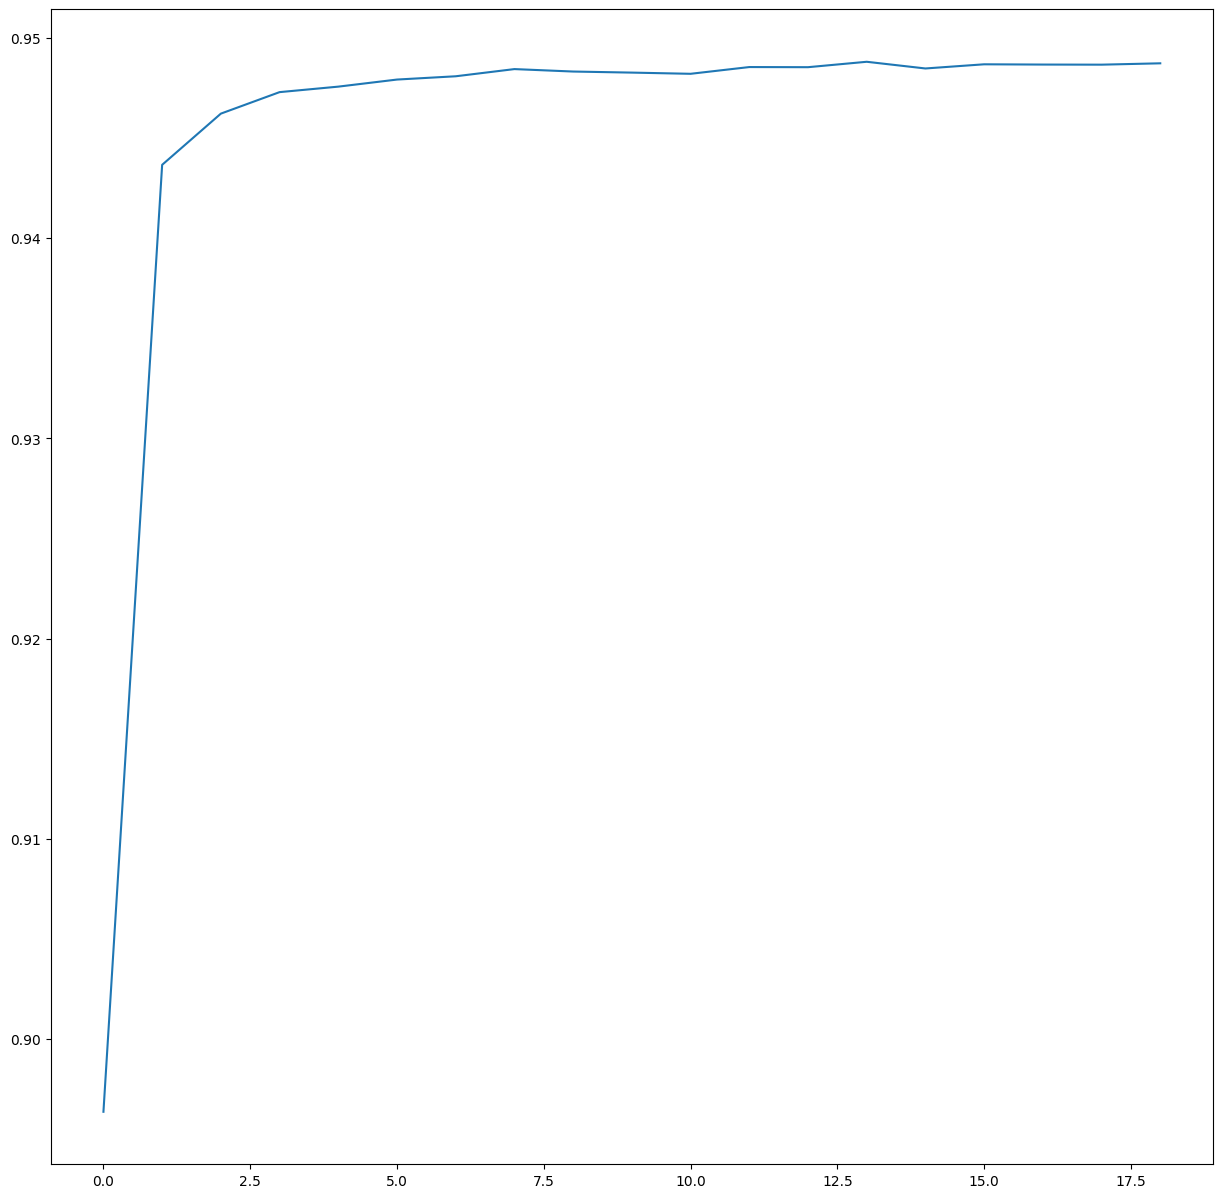

In [20]:
plt.figure(figsize=(15,15))
history1_df['accuracy'].plot()

In [24]:
def cross_validation(model, data, target):        
    avg_acc = 0
    avg_loss = 0
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(data,target,train_size=0.7)
        test = tf.reshape(x_test,(-1,17,1))
        score = model.evaluate(test,y_test)
        avg_loss+=score[0]
        avg_acc+=score[1]
    print(f'avg Test loss: {avg_loss/10} / avg Test accuracy: {avg_acc/10}')
    return avg_loss/10, avg_acc/10

In [25]:
cross_validation(model_cnn,data,target)

11272/11272 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9380 - loss: 0.1792
11272/11272 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9374 - loss: 0.1827
11272/11272 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9376 - loss: 0.1798
11272/11272 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9379 - loss: 0.1814
11272/11272 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9375 - loss: 0.1818
11272/11272 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9380 - loss: 0.1813
11272/11272 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9378 - loss: 0.1824
11272/11272 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.9375 - loss: 0.1808
11272/11272 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9370 - loss: 0.1843
11272/11272 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9371 - loss: 0.1814
avg Test loss: 0.1806441754102707 / avg Test accuracy: 0.937715870141983


(0.1806441754102707, 0.937715870141983)

In [27]:
# model_cnn.save('Cnn_model.h5')